In [16]:
import pandas as pd
import os
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

In [3]:
return_data = pd.read_csv("../Data/ReportReturn.csv")
# 定义年报文本文件所在目录
report_directory = '../Data/FilteredReports'

# 初始化一个新的列，用于存储文本内容
return_data['text'] = None

# 遍历DataFrame的每一行
for index, row in return_data.iterrows():
    # 根据pdf文件名生成对应的txt文件名
    report_name_pdf = row['report']
    report_name_txt = report_name_pdf.replace('.pdf', '.txt')
    
    # 构建txt文件的完整路径
    file_path = os.path.join(report_directory, report_name_txt)
    
    # 检查文件是否存在
    if os.path.exists(file_path):
        # 读取文件内容
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        
        # 将文本内容添加到DataFrame对应行
        return_data.at[index, 'text'] = text
    else:
        print(f"File not found: {file_path}")

# 查看结果
return_data.head()

,code,report,rtn1y,rtn2y,text
0,1,000001_平安银行_2020年年度报告.pdf,-0.132696,-0.176295,平安 银行 股份 有限公司 年 年度报告 重要 提示 平安 银行 股份 有限公司 年 年度报...
1,1,000001_平安银行_2021年年度报告.pdf,-0.176295,-0.241602,平安 银行 股份 有限公司 年 年度报告 重要 提示 平安 银行 股份 有限公司 年 年度报...
2,2,000002_万科A_2020年年度报告.pdf,-0.221323,-0.021555,万科 企业 股份 有限公司 年度报告 证券 代码 证券 简称 万科 万科 代 公告 编号 万...
3,2,000002_万科A_2021年年度报告.pdf,-0.021555,-0.266972,万科 企业 股份 有限公司 年度报告 证券 代码 证券 简称 万科 万科 代 公告 编号 万...
4,63,000063_中兴通讯_2020年年度报告.pdf,0.001382,-0.210217,二 二年 年度报告 全文 中兴通讯 股份 有限公司 中兴通讯 股份 有限公司 二 二年 年度...


In [17]:
# 训练Word2Vec模型
word2vec_model = Word2Vec(
    sentences=return_data['text'],
    vector_size=100,  # 词向量维度
    window=5,  # 窗口大小
    min_count=1,  # 忽略出现次数少于min_count的词
    workers=4  # 使用的CPU核心数量
)

# 计算每个报告的平均词向量
def compute_average_word_vectors(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 为每个报告计算平均词向量
return_data['avg_vector'] = return_data['text'].apply(lambda text: compute_average_word_vectors(text, word2vec_model))

# 准备特征矩阵X和目标变量y
X = np.vstack(return_data['avg_vector'].values)
y = return_data['rtn1y'].values  # 假设我们预测一年收益率

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 进行预测
y_pred = linear_model.predict(X_test)

# 计算均方误差
mse_word2vec = mean_squared_error(y_test, y_pred)
print(f"Word2Vec Model MSE: {mse_word2vec}")
print(f'Word2Vev Model R^2: {r2_score(y_test,y_pred)}')

Word2Vec Model MSE: 0.20755098739114353
Word2Vev Model R^2: -0.11661215204207354


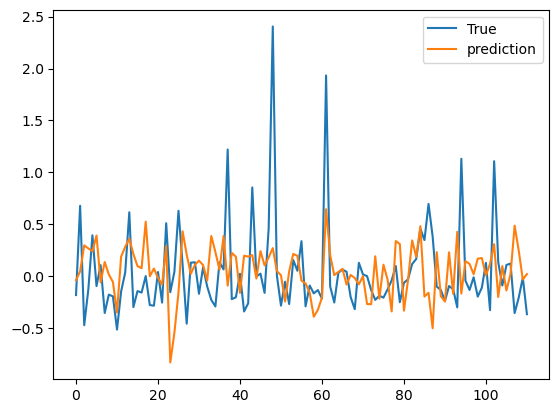

In [5]:
plt.plot(y_test,label='True')
plt.plot(y_pred,label='prediction')
plt.legend()

In [40]:
y2 = return_data['rtn2y'].dropna().values
X2_train,X2_test,y2_train,y2_test = train_test_split(X,y2,test_size=0.2,random_state=42)
model2 = LinearRegression()
model2.fit(X2_train,y2_train)
y2_pred = model2.predict(X2_test)
mse_word2vec2 = mean_squared_error(y2_test,y2_pred)
print(f'Word2Vec Model for year2 MSE:{mse_word2vec2}')

Word2Vec Model for year2 MSE:0.08093511477559644


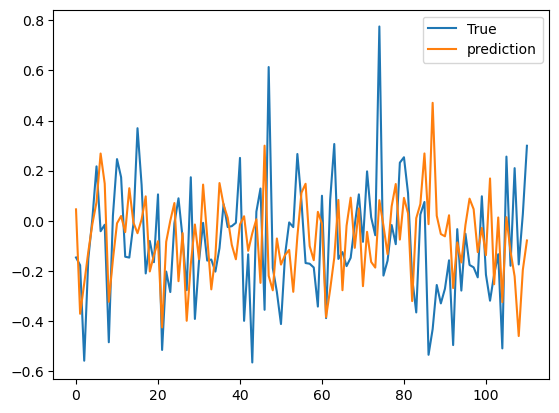

In [8]:
plt.plot(y2_test,label='True')
plt.plot(y2_pred,label='prediction')
plt.legend();

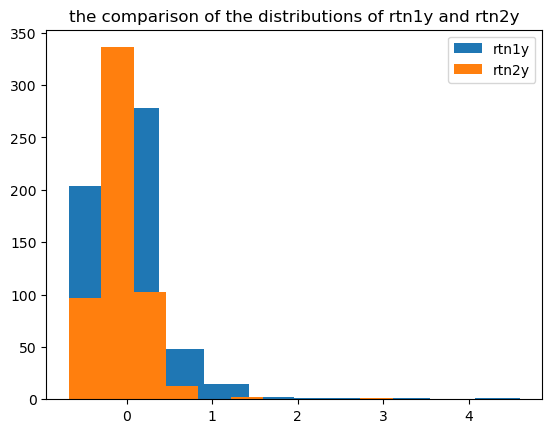

In [39]:
#the comparison of the distributions of rtn1y and rtn2y
plt.figure()
plt.hist(return_data['rtn1y'],bins=10,label='rtn1y');
plt.hist(return_data['rtn2y'],bins=10,label='rtn2y');
plt.title('the comparison of the distributions of rtn1y and rtn2y')
plt.legend()

In [18]:
res = pd.read_csv('../Data/res.csv',index_col=0)
mse_res = pd.read_csv('../Data/mse_res.csv',index_col=0)
res['word2vec_pred1y'] = y_pred
res['wordvec_pred2y'] = y2_pred
mse_res.loc['1y','word2vec_mse'] = mse_word2vec
mse_res.loc['2y','word2vec_mse'] = mse_word2vec2
res.to_csv('../Data/res.csv',)
mse_res.to_csv('../Data/mse_res.csv')

In [38]:
mse_res

,bag_countvectorizer_mse,bag_TfidfVectorizer_mse,doc2vec_mse,word2vec_mse
1y,0.426668,0.275374,0.201635,0.207551
2y,0.249207,0.215783,0.085591,0.069988
